In [1]:
import pandas as pd
from seaborn import xkcd_palette
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import numpy as np

In [9]:
# Read the scaled data
data = pd.read_csv("scaled_flood_drivers_dataset.csv")

# Define categories and their columns
categories = {
    "Labels": [col for col in data.columns if col.startswith('L')],
    "Topography": [col for col in data.columns if col.startswith('T')],
    "Hydrological": [col for col in data.columns if col.startswith('H')],
    "Vegetation": [col for col in data.columns if col.startswith('V')],
    "Shape": [col for col in data.columns if col.startswith('S')],
    "Climate": [col for col in data.columns if col.startswith('C')]
}

data.head()

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,...,C2,H2,H3,H4,H5,T5,H9,H10,H11,H12
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.323529,0.512363,0.411727,0.645739,0.043717,0.026230,0.499246,0.860465,0.165485,0.080574
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.014706,0.120433,0.382271,0.313518,0.005087,0.187186,0.198574,0.825581,0.138156,0.105436
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.039216,0.317187,0.424634,0.383745,0.100303,0.164638,0.086584,0.895349,0.491625,0.061172
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.029412,0.791865,0.447644,1.000000,0.010747,0.023688,0.082638,0.953488,0.122344,0.027002
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.078431,0.712032,0.706609,0.496820,0.009473,0.023073,0.302641,0.825581,0.594182,0.105843


### Correlation of each features in each catagory

Plotting correlation matrix for Labels...


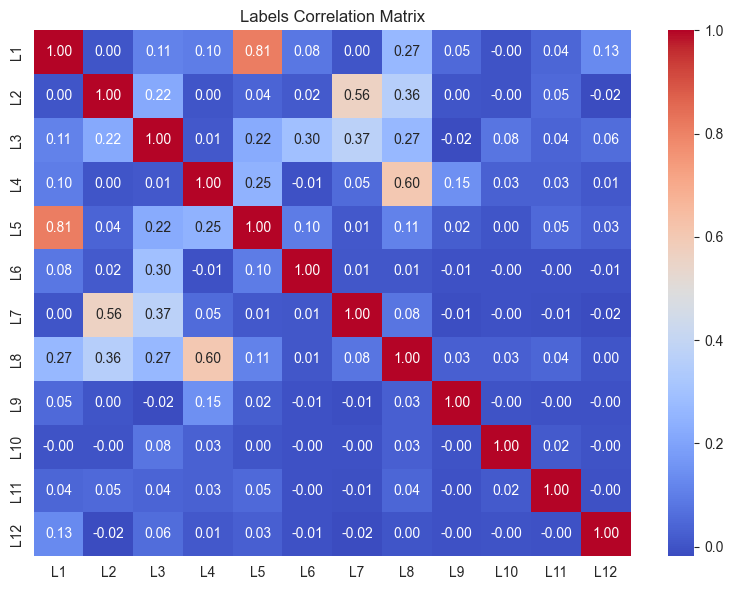

Plotting correlation matrix for Topography...


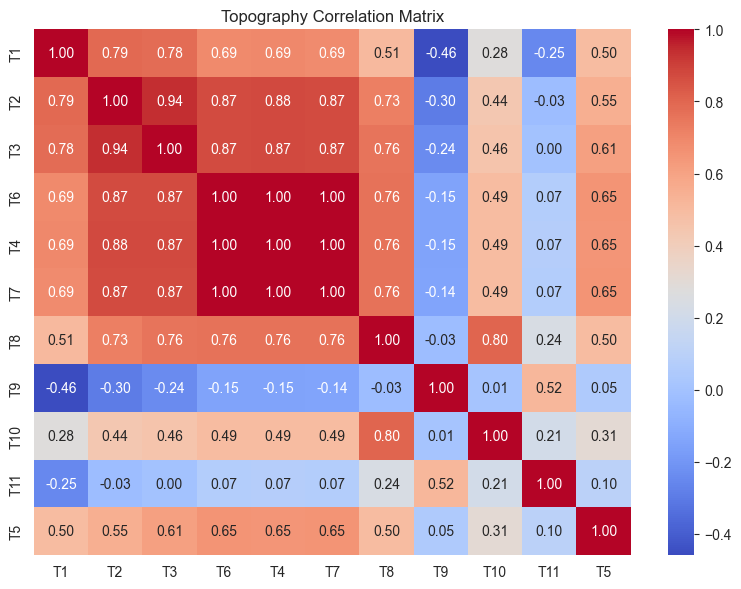

Plotting correlation matrix for Hydrological...


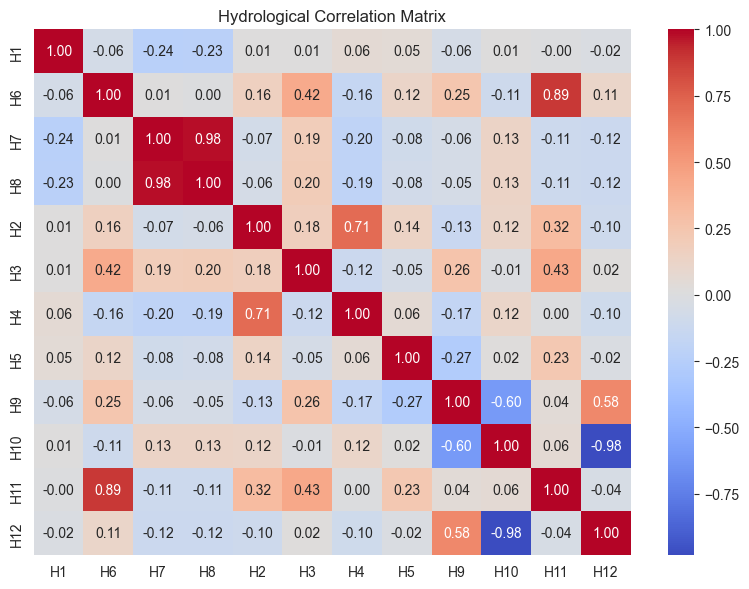

Plotting correlation matrix for Vegetation...


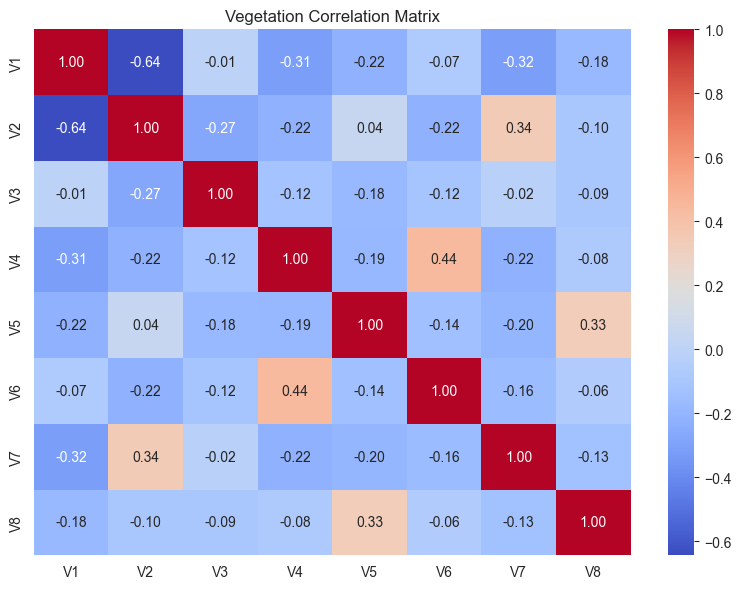

Plotting correlation matrix for Shape...


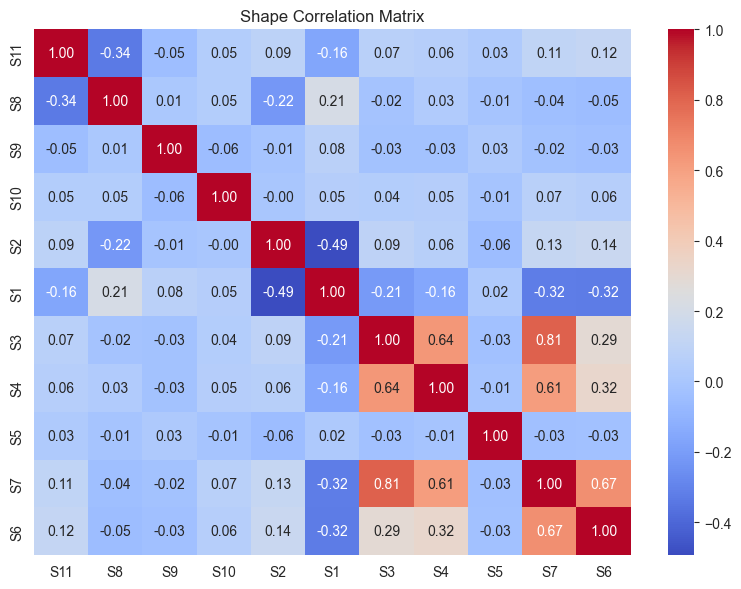

Plotting correlation matrix for Climate...


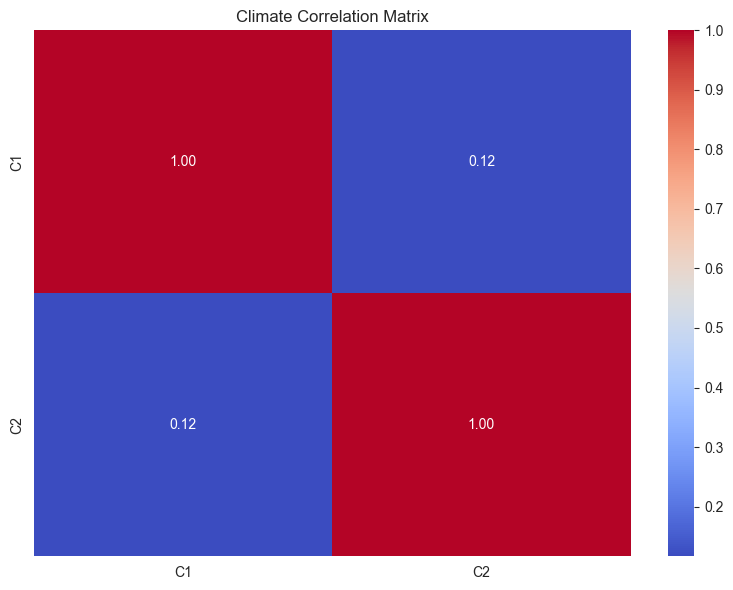

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot and save correlation matrix for each category
for category, columns in categories.items():
    if columns:  # Ensure the category has columns
        print(f"Plotting correlation matrix for {category}...")
        correlation_matrix = data[columns].corr()  # Compute correlation matrix
        plt.figure(figsize=(8, 6))  # Set figure size
        sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)  # Create heatmap
        plt.title(f"{category} Correlation Matrix")  # Add title
        plt.tight_layout()
        plt.savefig(f"{category}_correlation_matrix.png")  # Save plot as PNG
        plt.show()  # Display the plot


### Random forrest model

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

# Combine all features from categories into a single list
all_features = categories["Topography"] + categories["Hydrological"] + categories["Vegetation"] + categories["Shape"] + categories["Climate"]

# Create a DataFrame with feature columns
all_features_df = data[all_features]

# Create a DataFrame with label columns
labels_df = data[categories["Labels"]]

# Train a RandomForestRegressor to get feature importance (using mean of the labels for simplicity)
# Averaging labels as a target (basic approach when there are multiple labels)
labels_avg = labels_df.mean(axis=1)

# Train a random forest model to evaluate feature importances
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(all_features_df, labels_avg)

# Extract feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({
    'Feature': all_features_df.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Save the feature importance DataFrame to a CSV file
feature_importance_csv_path = 'feature_importance_fixed.csv'
feature_importance_df.to_csv(feature_importance_csv_path, index=False)

# Select features using SelectFromModel with threshold to only keep features above the median importance
selector = SelectFromModel(rf_model, threshold="median")
selector.fit(all_features_df, labels_avg)

# Get the selected features
selected_features = all_features_df.columns[selector.get_support()]

# Save the selected features to a CSV file
selected_features_csv_path = 'selected_features_fixed.csv'
pd.DataFrame(selected_features, columns=['Selected Features']).to_csv(selected_features_csv_path, index=False)

# Print paths for user convenience
print(f"Feature importance saved to: {feature_importance_csv_path}")
print(f"Selected features saved to: {selected_features_csv_path}")


Feature importance saved to: feature_importance_fixed.csv
Selected features saved to: selected_features_fixed.csv


### Mutual information & RFE


In [12]:
from sklearn.feature_selection import RFE, mutual_info_regression



# Combine all features from categories into a single list
all_features = categories["Topography"] + categories["Hydrological"] + categories["Vegetation"] + categories["Shape"] + categories["Climate"]

# Create a DataFrame with feature columns
all_features_df = data[all_features]

# Create a DataFrame with label columns
labels_df = data[categories["Labels"]]

# Averaging labels as a target (basic approach when there are multiple labels)
labels_avg = labels_df.mean(axis=1)

# 1. Recursive Feature Elimination (RFE) with RandomForestRegressor
# Using a RandomForestRegressor as an estimator to iteratively select features
rfe_selector = RFE(estimator=RandomForestRegressor(n_estimators=50, random_state=42), n_features_to_select=20, step=1)
rfe_selector.fit(all_features_df, labels_avg)

# Get the selected features from RFE
rfe_selected_features = all_features_df.columns[rfe_selector.support_]

# Save the RFE selected features to a CSV file
rfe_selected_features_list = list(rfe_selected_features)
rfe_selected_features_csv_path = 'rfe_selected_features.csv'
pd.DataFrame(rfe_selected_features_list, columns=['RFE Selected Features']).to_csv(rfe_selected_features_csv_path, index=False)

# 2. Mutual Information Analysis for Feature Selection
# Calculating the mutual information scores for each feature
mi_scores = mutual_info_regression(all_features_df, labels_avg)
mi_feature_importance_df = pd.DataFrame({
    'Feature': all_features_df.columns,
    'Mutual Information Score': mi_scores
}).sort_values(by='Mutual Information Score', ascending=False)

# Save the mutual information scores to a CSV file
mi_scores_csv_path = 'mutual_information_scores.csv'
mi_feature_importance_df.to_csv(mi_scores_csv_path, index=False)

# Print paths for saved CSV files
print(f"RFE selected features saved to: {rfe_selected_features_csv_path}")
print(f"Mutual information scores saved to: {mi_scores_csv_path}")


RFE selected features saved to: rfe_selected_features.csv
Mutual information scores saved to: mutual_information_scores.csv


### PCA

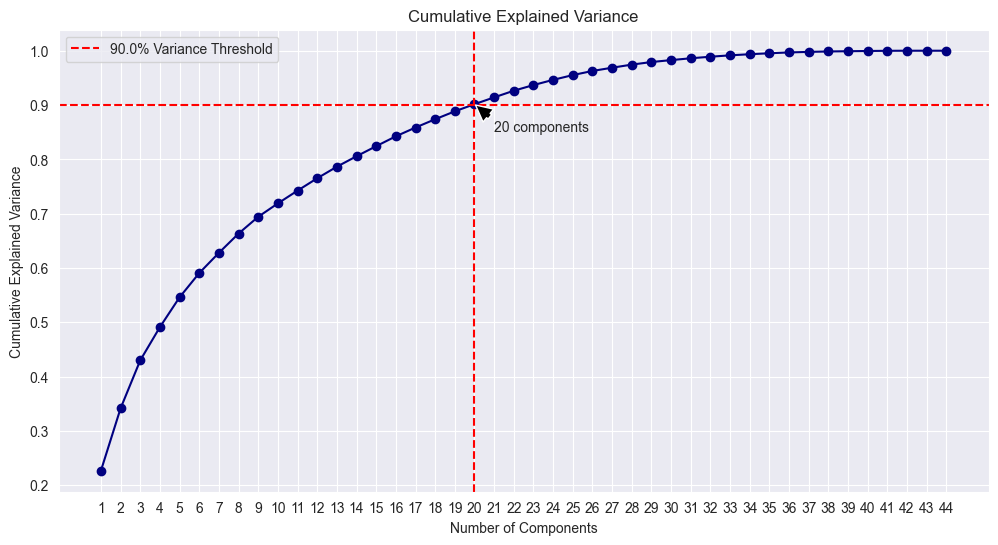

Number of components explaining 90% variance: 20
PCA-transformed features saved to: pca_features.csv


In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Combine all features from categories into a single list
all_features = categories["Topography"] + categories["Hydrological"] + categories["Vegetation"] + categories["Shape"] + categories["Climate"]

# Create a DataFrame with feature columns
all_features_df = data[all_features]

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(all_features_df)

# Step 2: Apply PCA
# Fit PCA to the data and keep enough components to explain 95% of the variance
pca = PCA()
pca.fit(scaled_features)

# Transform the features using PCA
pca_features = pca.transform(scaled_features)

# Calculate the cumulative explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

# Determine the number of components needed to explain 95% of the variance
threshold = 0.90
components_needed = np.argmax(cumulative_explained_variance >= threshold) + 1

# Create a DataFrame for the PCA-transformed features
pca_columns = [f'PC{i+1}' for i in range(components_needed)]
pca_features_df = pd.DataFrame(pca_features[:, :components_needed], columns=pca_columns)

# Save the PCA-transformed features to a CSV file
pca_features_csv_path = 'pca_features.csv'
pca_features_df.to_csv(pca_features_csv_path, index=False)

# Plot the cumulative explained variance
components = np.arange(1, len(explained_variance) + 1)

plt.figure(figsize=(12, 6))
plt.plot(components, cumulative_explained_variance, marker='o', linestyle='-', color='navy')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(components)
plt.grid(True)

# Annotate the point where cumulative variance exceeds 95%
plt.axhline(y=threshold, color='red', linestyle='--', label=f'{threshold*100}% Variance Threshold')
plt.axvline(x=components_needed, color='red', linestyle='--')
plt.annotate(f'{components_needed} components', xy=(components_needed, cumulative_explained_variance[components_needed - 1]),
             xytext=(components_needed + 1, cumulative_explained_variance[components_needed - 1] - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.legend()
plt.show()

# Print the results
print(f"Number of components explaining 90% variance: {components_needed}")
print(f"PCA-transformed features saved to: {pca_features_csv_path}")


In [15]:
# Calculate the PCA loadings matrix
# Loadings represent how much each feature contributes to each retained principal component
loadings = pca.components_.T[:, :len(pca_columns)] * np.sqrt(pca.explained_variance_[:len(pca_columns)])

# Create a DataFrame for the PCA loadings
loadings_df = pd.DataFrame(loadings, index=all_features_df.columns, columns=pca_columns)

# Find the top contributing features for each principal component
top_features_per_component = {}

# Identify the top 5 features contributing to each principal component
for pc in pca_columns:
    top_features_per_component[pc] = (
        loadings_df[pc].abs().sort_values(ascending=False).head(5).index.tolist()
    )

# Save the loadings matrix to a CSV file
loadings_csv_path = 'pca_loadings.csv'
loadings_df.to_csv(loadings_csv_path, index=True)

# Save the top contributing features to a CSV file
top_features_csv_path = 'top_features_per_component_PCA.csv'
top_features_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in top_features_per_component.items()]))
top_features_df.to_csv(top_features_csv_path, index=False)

# Print file paths for confirmation
print(f"PCA loadings saved to: {loadings_csv_path}")
print(f"Top contributing features saved to: {top_features_csv_path}")


PCA loadings saved to: pca_loadings.csv
Top contributing features saved to: top_features_per_component_PCA.csv


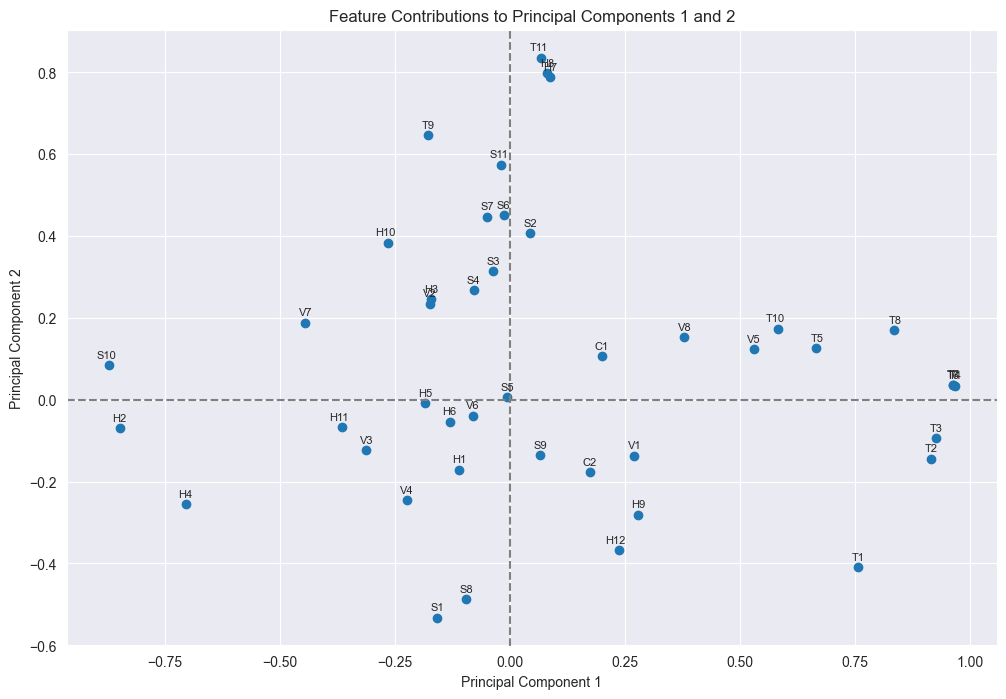

In [16]:

# Plotting the contributions of the original features to the first two principal components
plt.figure(figsize=(12, 8))

# We will focus on the first two principal components (PC1 and PC2)
pc1_loadings = loadings_df['PC1']
pc2_loadings = loadings_df['PC2']

# Create a scatter plot for the loadings of PC1 vs PC2
plt.scatter(pc1_loadings, pc2_loadings)

# Annotate each point with the feature name
for feature, x, y in zip(loadings_df.index, pc1_loadings, pc2_loadings):
    plt.annotate(feature, (x, y), textcoords="offset points", xytext=(5,5), ha='right', fontsize=8)

# Setting labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Feature Contributions to Principal Components 1 and 2')
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')

# Show the plot
plt.grid(True)
plt.show()


In [17]:
# Calculate the absolute sum of loadings for each feature across all components
loadings_sum = loadings_df.abs().sum(axis=1)

# Get the top 13 features based on the sum of absolute loadings across all principal components
top_13_features_final = loadings_sum.sort_values(ascending=False).head(18).index.tolist()

# Display the top 13 features
top_13_features_final


['V8',
 'C2',
 'V3',
 'S2',
 'T10',
 'S11',
 'V1',
 'V7',
 'S8',
 'V2',
 'S9',
 'V4',
 'V5',
 'H1',
 'H3',
 'C1',
 'H5',
 'H12']

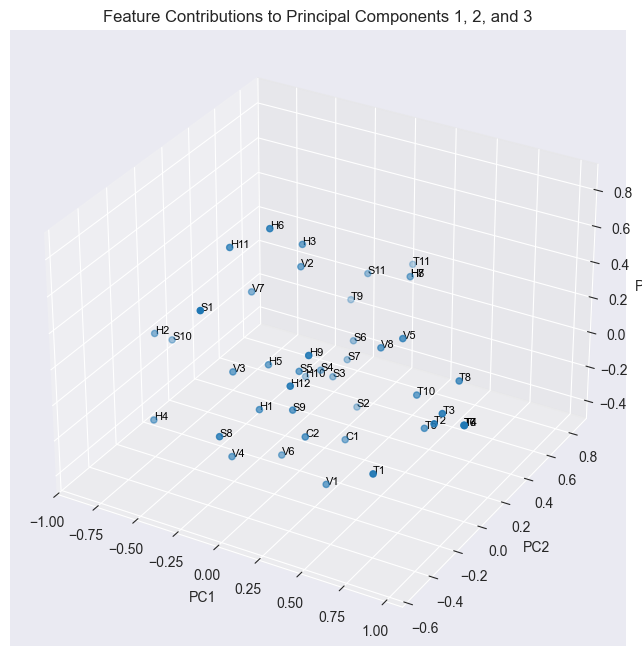

In [18]:
# Plotting the contributions of the original features to the first three principal components
from mpl_toolkits.mplot3d import Axes3D

# Plotting the contributions of the original features to PC1, PC2, and PC3
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract PC1, PC2, and PC3 loadings
pc1_loadings = loadings_df['PC1']
pc2_loadings = loadings_df['PC2']
pc3_loadings = loadings_df['PC3']

# Scatter plot for PC1, PC2, and PC3 loadings
ax.scatter(pc1_loadings, pc2_loadings, pc3_loadings)

# Annotate each point with the feature name (using updated category names)
for feature, x, y, z in zip(loadings_df.index, pc1_loadings, pc2_loadings, pc3_loadings):
    ax.text(x, y, z, feature, size=8, zorder=1, color='k')

# Setting labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Feature Contributions to Principal Components 1, 2, and 3')

# Show the plot
plt.show()

In [19]:

# Reload the uploaded files
rfe_features = pd.read_csv('rfe_selected_features.csv')
selected_features_fixed = pd.read_csv('selected_features_fixed.csv')
top_pca_features = pd.read_csv('top_features_per_component_PCA.csv')
mutual_info_features = pd.read_csv('mutual_information_scores.csv')

# Extract relevant features from each method
rfe_features_list = rfe_features['RFE Selected Features'].tolist()
selected_features_list = selected_features_fixed['Selected Features'].tolist()

# Flatten the PCA top features dataframe
top_pca_features_list = top_pca_features.values.flatten()
top_pca_features_list = [feature for feature in top_pca_features_list if pd.notna(feature)]

# Extract top mutual information features (non-zero scores)
top_mutual_info_features = mutual_info_features[mutual_info_features['Mutual Information Score'] > 0]
mutual_info_features_list = top_mutual_info_features['Feature'].tolist()

# Combine all results into a dictionary
features_summary = {
    "RFE Selected Features": rfe_features_list,
    "Random Forest Importance Selected Features": selected_features_list,
    "Top PCA Features": top_pca_features_list,
    "Top Mutual Information Features": mutual_info_features_list
}

# Display combined results
features_summary


{'RFE Selected Features': ['T1',
  'T4',
  'T9',
  'T10',
  'T11',
  'H3',
  'H4',
  'H5',
  'H9',
  'H12',
  'V1',
  'V2',
  'V3',
  'V4',
  'V6',
  'V7',
  'S9',
  'S3',
  'C1',
  'C2'],
 'Random Forest Importance Selected Features': ['T1',
  'T8',
  'T9',
  'T10',
  'H1',
  'H3',
  'H4',
  'H5',
  'H9',
  'V1',
  'V2',
  'V3',
  'V4',
  'V6',
  'V7',
  'S9',
  'S3',
  'S4',
  'S5',
  'S7',
  'C1',
  'C2'],
 'Top PCA Features': ['T4',
  'T11',
  'H6',
  'S7',
  'H10',
  'V1',
  'V3',
  'H5',
  'H5',
  'V8',
  'S5',
  'H1',
  'S6',
  'S2',
  'V3',
  'S9',
  'V6',
  'S8',
  'S11',
  'V8',
  'T6',
  'H8',
  'H11',
  'S3',
  'H12',
  'V2',
  'S9',
  'V4',
  'H12',
  'S5',
  'H1',
  'S5',
  'S3',
  'S5',
  'C1',
  'C1',
  'C2',
  'T10',
  'H5',
  'T9',
  'T7',
  'H7',
  'S1',
  'S4',
  'V4',
  'C1',
  'V7',
  'C2',
  'C2',
  'S9',
  'V8',
  'S9',
  'S4',
  'S8',
  'S2',
  'V7',
  'V5',
  'H5',
  'V5',
  'S11',
  'T3',
  'T9',
  'H3',
  'S6',
  'H9',
  'H9',
  'V2',
  'T5',
  'H10',
  'S11

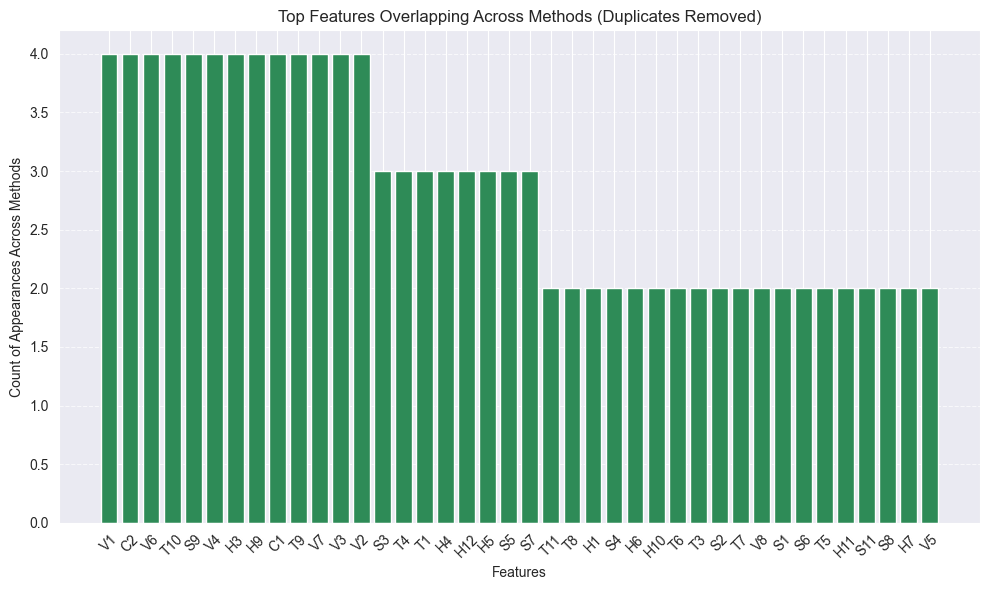

,Feature,Count
0,V1,4
2,C2,4
3,V6,4
10,T10,4
4,S9,4


In [20]:

# Ensure each feature appears only once per method
rfe_features_unique = set(rfe_features_list)
selected_features_unique = set(selected_features_list)
top_pca_features_unique = set(top_pca_features_list)
mutual_info_features_unique = set(mutual_info_features_list)

# Combine all unique features across methods
all_unique_features_combined = (
        list(rfe_features_unique) +
        list(selected_features_unique) +
        list(top_pca_features_unique) +
        list(mutual_info_features_unique)
)

# Recalculate feature counts
from collections import Counter
feature_counts_fixed = Counter(all_unique_features_combined)

# Create DataFrame for visualization
feature_overlap_fixed_df = pd.DataFrame({
    "Feature": feature_counts_fixed.keys(),
    "Count": feature_counts_fixed.values()
}).sort_values(by="Count", ascending=False)

# Display corrected features that appear in multiple methods
features_in_multiple_methods_fixed = feature_overlap_fixed_df[feature_overlap_fixed_df['Count'] > 1]

# Visualize the corrected results
plt.figure(figsize=(10, 6))
plt.bar(features_in_multiple_methods_fixed['Feature'], features_in_multiple_methods_fixed['Count'], color='seagreen')
plt.title("Top Features Overlapping Across Methods (Duplicates Removed)")
plt.xlabel("Features")
plt.ylabel("Count of Appearances Across Methods")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display results
features_in_multiple_methods_fixed.head()


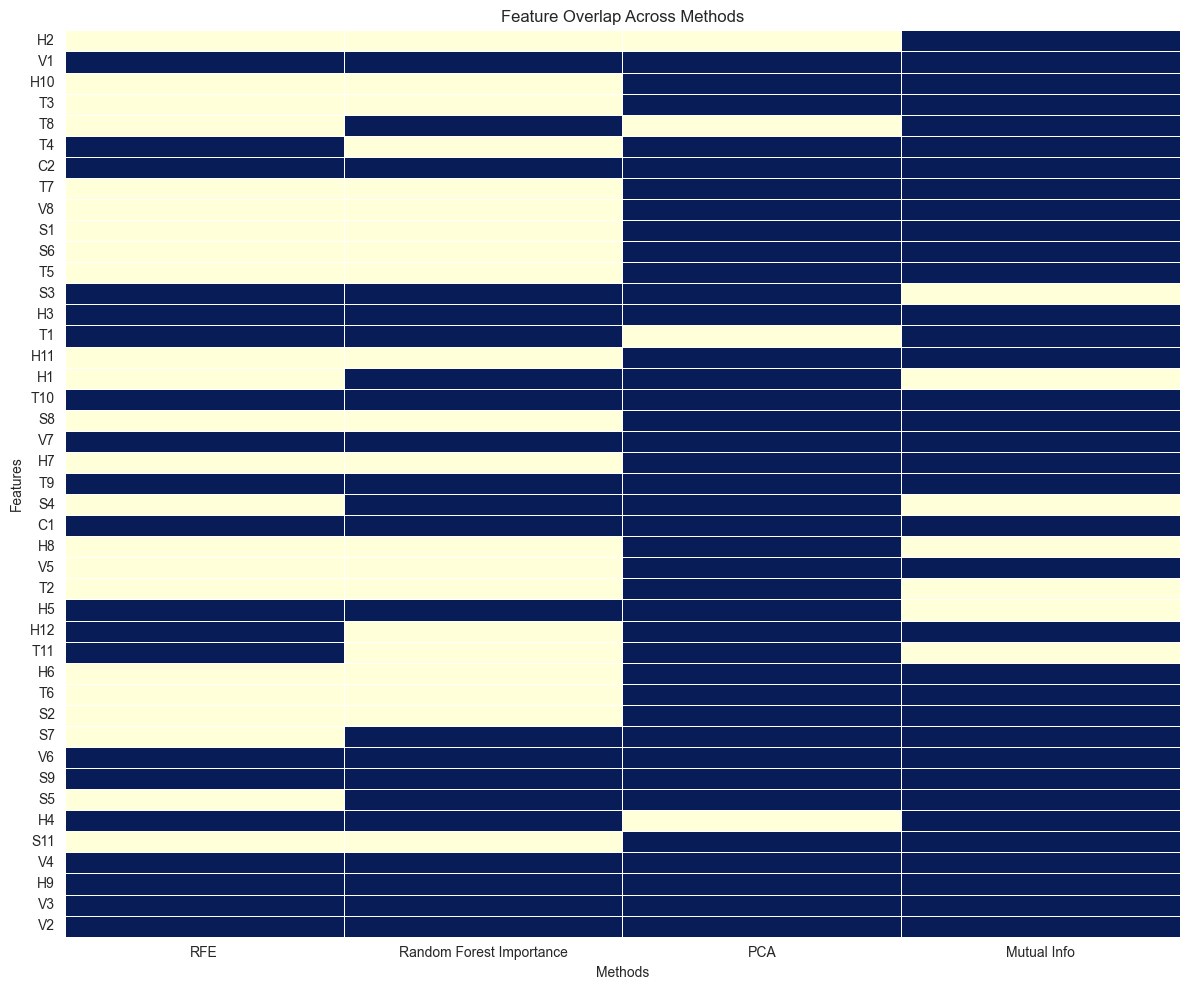

In [21]:

import seaborn as sns

# Create a binary DataFrame indicating feature presence in each method
unique_features = list(set(rfe_features_unique) | set(selected_features_unique) |
                       set(top_pca_features_unique) | set(mutual_info_features_unique))

# Initialize DataFrame
overlap_matrix = pd.DataFrame(0, index=unique_features, columns=["RFE", "Random Forest Importance", "PCA", "Mutual Info"])

# Mark features selected by each method
for feature in rfe_features_unique:
    overlap_matrix.at[feature, "RFE"] = 1
for feature in selected_features_unique:
    overlap_matrix.at[feature, "Random Forest Importance"] = 1
for feature in top_pca_features_unique:
    overlap_matrix.at[feature, "PCA"] = 1
for feature in mutual_info_features_unique:
    overlap_matrix.at[feature, "Mutual Info"] = 1

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(overlap_matrix, cmap="YlGnBu", linewidths=0.5, cbar=False, annot=False)
plt.title("Feature Overlap Across Methods")
plt.ylabel("Features")
plt.xlabel("Methods")
plt.tight_layout()
plt.show()


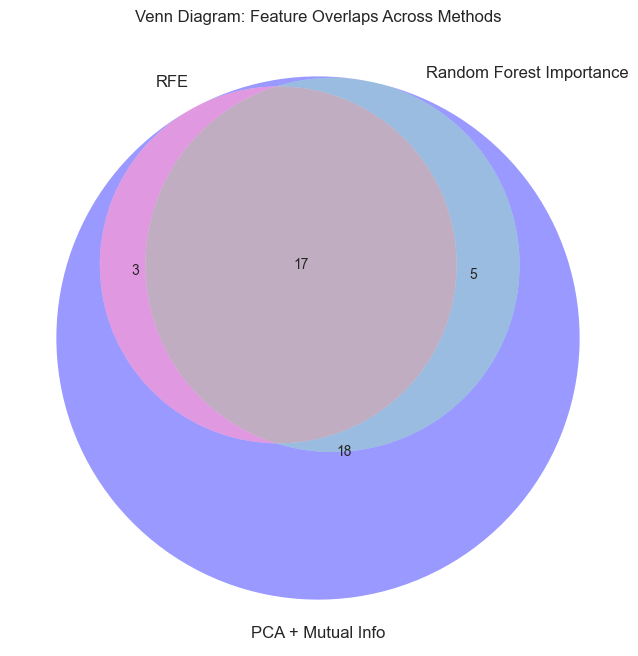

In [22]:
# Re-import necessary modules and reload unique sets
from matplotlib_venn import venn3


# Extract and deduplicate unique features
rfe_features_unique = set(rfe_features['RFE Selected Features'].tolist())
selected_features_unique = set(selected_features_fixed['Selected Features'].tolist())
top_pca_features_unique = set(top_pca_features.values.flatten())
top_pca_features_unique = {feature for feature in top_pca_features_unique if pd.notna(feature)}
mutual_info_features_unique = set(mutual_info_features[mutual_info_features['Mutual Information Score'] > 0]['Feature'].tolist())

# Combine PCA and Mutual Information features for venn3
top_combined_features = top_pca_features_unique.union(mutual_info_features_unique)

# Generate Venn diagram for RFE, Median Importance, and PCA + Mutual Info
plt.figure(figsize=(10, 8))
venn = venn3([rfe_features_unique, selected_features_unique, top_combined_features],
             set_labels=('RFE', 'Random Forest Importance', 'PCA + Mutual Info'))
plt.title("Venn Diagram: Feature Overlaps Across Methods")
plt.show()


In [23]:
# Combine all features into a single Counter to get importance counts
from collections import Counter

# Combine unique features (deduplicate within methods)
all_features_combined = (
        list(rfe_features_unique) +
        list(selected_features_unique) +
        list(top_pca_features_unique) +
        list(mutual_info_features_unique)
)

# Count occurrences of each feature
feature_counts = Counter(all_features_combined)

# Sort features based on occurrence
sorted_features_df = pd.DataFrame(
    sorted(feature_counts.items(), key=lambda x: x[1], reverse=True),
    columns=['Feature', 'Count']
)

# Select top 20 features
top_20_features = sorted_features_df['Feature'].head(20).tolist()
print("Top 20 Recommended Features for Neural Network:")
print(top_20_features)


Top 20 Recommended Features for Neural Network:
['V1', 'C2', 'V6', 'S9', 'H3', 'V4', 'T10', 'V7', 'T9', 'C1', 'H9', 'V3', 'V2', 'T4', 'S3', 'H4', 'T1', 'H5', 'H12', 'S7']
